In [93]:
import pandas as pd
import QuantLib as ql
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

def real_test_data(df, frac):
    real_test_df = df.sample(frac=frac).reset_index(drop=True)
    return real_test_df

def slice_data(df, slicer, ratio):
    if (slicer < 1):
        new_df = df.drop(df.iloc[::int(1/slicer)].index, 0)
    else:
        new_df = df.iloc[::slicer]
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    new_df_size = new_df.shape[0]
    train = new_df[:int(new_df_size*ratio)]
    test = new_df[int(new_df_size*ratio):]
    return new_df_size, train, test

def prepare_data(train, test):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_training = scaler.fit_transform(train)
    scaled_testing = scaler.transform(test)
    scaled_training_df = pd.DataFrame(scaled_training,columns=train.columns.values)
    scaled_testing_df = pd.DataFrame(scaled_testing,columns=test.columns.values)
    X_train = scaled_training_df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    Y_train = scaled_training_df['call_price'].values
    X_test = scaled_testing_df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    Y_test = scaled_testing_df['call_price'].values
    
    return (X_train, Y_train, X_test, Y_test, scaler)

def model_results(X_train, Y_train, X_test, Y_test, real_X, real_Y):
    
    model = Sequential()
    model.add(Dense(50,input_dim=6,activation ='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])

    '''
    callbacks = [
        keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor='val_loss',
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-4,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=3,
            verbose=1)
    ]
    '''

    history = model.fit(X_train, Y_train, epochs=15, validation_split=0.2,
            shuffle=True, verbose=2)
    test_error_rate = model.evaluate(X_test, Y_test, verbose=0)
    stats = {}
    real_stats = {}
    metrics_names = model.metrics_names
    for i in range(len(metrics_names)):
        stats[metrics_names[i]] = test_error_rate[i]
    
    real_error_rate = model.evaluate(real_X, real_Y, verbose=0)
    for i in range(len(metrics_names)):
        real_stats[metrics_names[i]] = real_error_rate[i]
        
    return history, stats, real_stats



In [31]:
df = pd.read_pickle('uniform_data_1m.pkl')
real_test_df = real_test_data(df, 0.1)

ratio = 0.8
slicers = [30, 20, 15, 12, 10, 7, 5, 3, 2, 0.25]
diagonosis_df = pd.DataFrame()
sizes = []
stats = []
loss = []
real_loss = []
mae = []
history = []
scalers = []
real_test_stats = []
for i in slicers:
    size, train, test = slice_data(df, i, ratio)
    X_train, Y_train, X_test, Y_test, scaler = prepare_data(train, test)
    scaled_real_test = real_test_df
    scaled_real_test = scaler.transform(scaled_real_test)
    scaled_real_test = pd.DataFrame(scaled_real_test,columns=test.columns.values)
    real_test_X = scaled_real_test[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    real_test_Y = scaled_real_test['call_price'].values
    model_history, model_stats, real_test_stat = model_results(X_train, Y_train, X_test, Y_test, real_test_X, real_test_Y)
    sizes.append(size)
    scalers.append(scaler)
    history.append(model_history)
    loss.append(model_stats['loss'])
    real_loss.append((model_stats['loss'] - scaler.min_[6])/scaler.scale_[6])
    stats.append(model_stats)
    mae.append(model_stats['mae'])
    real_test_stats.append(real_test_stat)

Train on 21333 samples, validate on 5334 samples
Epoch 1/15
 - 2s - loss: 0.0021 - mae: 0.0223 - val_loss: 1.3839e-04 - val_mae: 0.0088
Epoch 2/15
 - 2s - loss: 1.2877e-04 - mae: 0.0084 - val_loss: 1.2535e-04 - val_mae: 0.0084
Epoch 3/15
 - 2s - loss: 8.6578e-05 - mae: 0.0069 - val_loss: 5.1978e-05 - val_mae: 0.0052
Epoch 4/15
 - 2s - loss: 8.2774e-05 - mae: 0.0065 - val_loss: 3.9092e-05 - val_mae: 0.0046
Epoch 5/15
 - 2s - loss: 5.8262e-05 - mae: 0.0055 - val_loss: 3.2040e-05 - val_mae: 0.0041
Epoch 6/15
 - 2s - loss: 5.8000e-05 - mae: 0.0054 - val_loss: 9.8142e-05 - val_mae: 0.0077
Epoch 7/15
 - 2s - loss: 5.0088e-05 - mae: 0.0050 - val_loss: 3.5252e-05 - val_mae: 0.0043
Epoch 8/15
 - 2s - loss: 4.3957e-05 - mae: 0.0047 - val_loss: 1.8702e-05 - val_mae: 0.0031
Epoch 9/15
 - 2s - loss: 3.7075e-05 - mae: 0.0043 - val_loss: 3.1000e-05 - val_mae: 0.0042
Epoch 10/15
 - 2s - loss: 5.5134e-05 - mae: 0.0049 - val_loss: 4.1218e-05 - val_mae: 0.0053
Epoch 11/15
 - 2s - loss: 2.6289e-05 - mae: 

Epoch 13/15
 - 9s - loss: 8.1051e-06 - mae: 0.0019 - val_loss: 7.1030e-06 - val_mae: 0.0019
Epoch 14/15
 - 9s - loss: 7.9595e-06 - mae: 0.0018 - val_loss: 1.2751e-05 - val_mae: 0.0026
Epoch 15/15
 - 9s - loss: 8.9228e-06 - mae: 0.0018 - val_loss: 2.5562e-06 - val_mae: 0.0011
Train on 128000 samples, validate on 32000 samples
Epoch 1/15
 - 12s - loss: 5.3445e-04 - mae: 0.0103 - val_loss: 4.2668e-05 - val_mae: 0.0048
Epoch 2/15
 - 12s - loss: 4.9021e-05 - mae: 0.0050 - val_loss: 2.4188e-05 - val_mae: 0.0035
Epoch 3/15
 - 12s - loss: 3.2239e-05 - mae: 0.0040 - val_loss: 8.5104e-05 - val_mae: 0.0061
Epoch 4/15
 - 12s - loss: 2.2956e-05 - mae: 0.0033 - val_loss: 1.0264e-05 - val_mae: 0.0024
Epoch 5/15
 - 12s - loss: 1.5375e-05 - mae: 0.0027 - val_loss: 1.5653e-05 - val_mae: 0.0029
Epoch 6/15
 - 12s - loss: 1.3143e-05 - mae: 0.0025 - val_loss: 1.6663e-05 - val_mae: 0.0033
Epoch 7/15
 - 12s - loss: 1.1178e-05 - mae: 0.0022 - val_loss: 3.9985e-06 - val_mae: 0.0015
Epoch 8/15
 - 12s - loss: 1.0

[33334, 50000, 66667, 83334, 100000, 142858, 200000, 333334, 500000, 750000]
[2.4864882471711056e-05, 5.6915873996331355e-06, 2.2289834892551628e-05, 2.6645200428398396e-05, 2.310791872332629e-06, 2.520636248439322e-06, 2.593462974209615e-06, 1.0566126853092508e-06, 2.6709078861131273e-06, 5.455854657945262e-07]
[{'loss': 2.4134498604107647e-05, 'mae': 0.0035516670905053616}, {'loss': 5.404815927577146e-06, 'mae': 0.0017869637813419104}, {'loss': 0.00019369519077125006, 'mae': 0.009023314341902733}, {'loss': 2.6212755831656976e-05, 'mae': 0.003766158362850547}, {'loss': 3.2835751818493007e-06, 'mae': 0.0013145713601261377}, {'loss': 2.500489741214551e-06, 'mae': 0.0010816206922754645}, {'loss': 4.005149547898327e-05, 'mae': 0.0037523286882787943}, {'loss': 1.055449690511523e-06, 'mae': 0.0007200910476967692}, {'loss': 2.6507023755584667e-06, 'mae': 0.0011373774614185095}, {'loss': 5.422903337012031e-07, 'mae': 0.0005664816126227379}]
[0.003609704552218318, 0.0018474723910912871, 0.0033

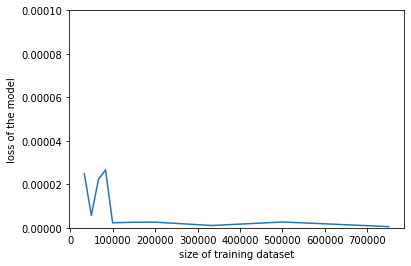

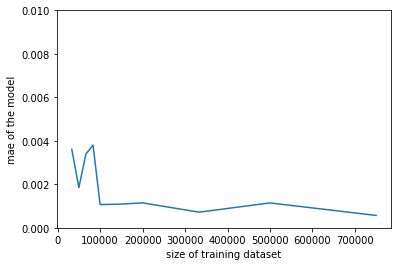

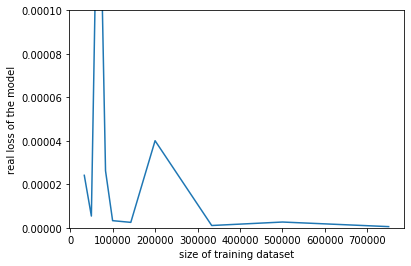

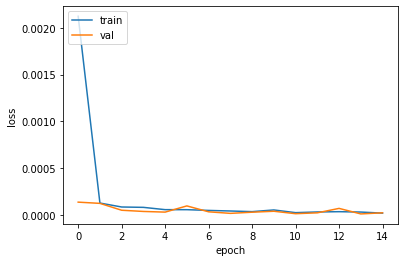

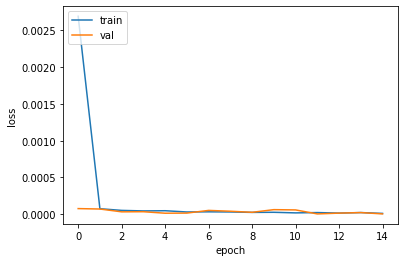

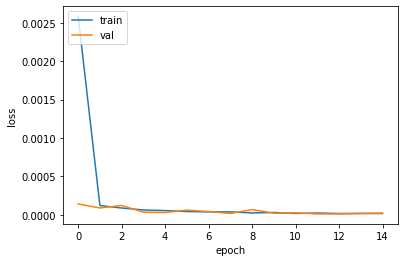

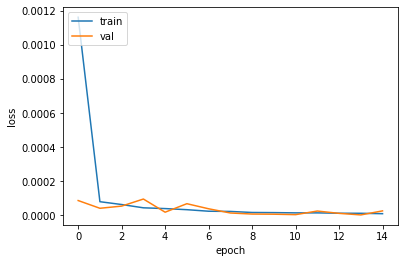

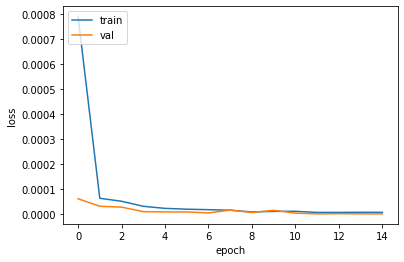

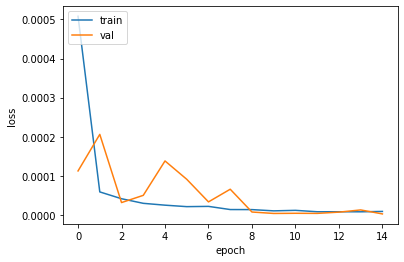

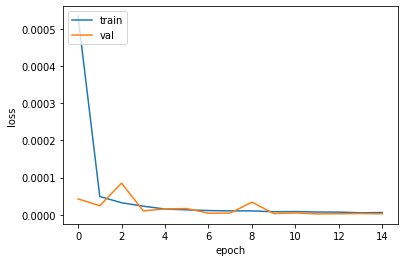

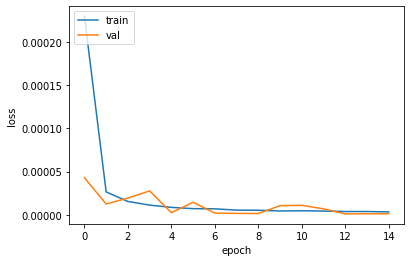

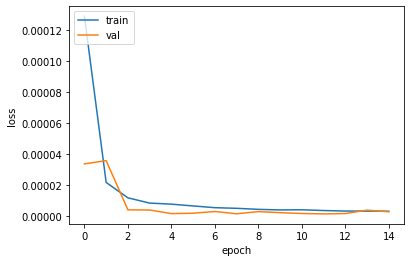

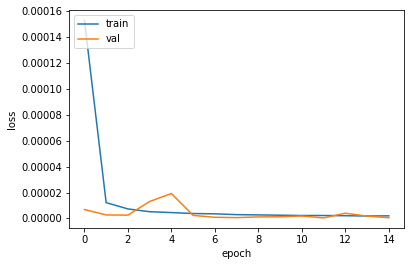

In [32]:
import matplotlib.pyplot as plt
print(sizes)
print(loss)
print(real_test_stats)
print(mae)
plt.plot(sizes, loss)
plt.xlabel('size of training dataset')
plt.ylabel('loss of the model')
plt.ylim(0,0.0001)
plt.show()

plt.plot(sizes, mae)
plt.xlabel('size of training dataset')
plt.ylabel('mae of the model')
plt.ylim(0,0.01)
plt.show()

plt.plot(sizes, [ sub['loss'] for sub in real_test_stats] )
plt.xlabel('size of training dataset')
plt.ylabel('real loss of the model')
plt.ylim(0,0.0001)
plt.show()

for i in history:
    plt.plot(i.history['loss'])
    plt.plot(i.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [94]:
import matplotlib.pyplot as plt

df = pd.read_pickle('uniform_data_1m.pkl')
#df['moneyness'] = df['stock_price']/df['strike_price']

#plt.scatter(df['moneyness'], df['call_price'])

plt.show()


In [98]:
def slice_data_biased(df, slicer, ratio, bias_ratio):
    df['moneyness'] = df['stock_price']/df['strike_price']
    #df.sort_values(by=['moneyness'])
    if (slicer < 1):
        new_df_size = (1-slicer)*(df.shape[0])
    else:
        new_df_size = (df.shape[0])/slicer
        
    normal_moneyness_num = int(new_df_size*bias_ratio)
    out_moneyness_num = int(new_df_size - normal_moneyness_num)
    
    normal_moneyness_df = df.loc[df['moneyness'] <= 10]

    out_moneyness_df = df.loc[df['moneyness'] > 10]

    normal_moneyness_df = normal_moneyness_df.sample(n=normal_moneyness_num)
    out_moneyness_df = out_moneyness_df.sample(n=out_moneyness_num)

    new_df = pd.concat([normal_moneyness_df, out_moneyness_df]).sample(frac=1).reset_index(drop=True)
    new_df = new_df.drop(columns = ['moneyness'])
    df = df.drop(columns = ['moneyness'])

    new_df_size = new_df.shape[0]
    train = new_df[:int(new_df_size*ratio)]
    test = new_df[int(new_df_size*ratio):]
    print(df.info)
    return new_df_size, train, test


In [108]:
df = pd.read_pickle('uniform_data_1m.pkl')
real_test_df = real_test_data(df, 0.1)

ratio = 0.8
slicers = [30, 20, 15, 13, 10, 7]
sizes = []
stats = []
loss = []
real_loss = []
mae = []
history = []
scalers = []
real_test_stats = []

new_sizes = []
new_stats = []
new_loss = []
new_real_loss = []
new_mae = []
new_history = []
new_scalers = []
new_real_test_stats = []

for i in slicers:
    size, train, test = slice_data_biased(df, i, ratio, ratio)
    X_train, Y_train, X_test, Y_test, scaler = prepare_data(train, test)
    scaled_real_test = real_test_df
    scaled_real_test = scaler.transform(scaled_real_test)
    scaled_real_test = pd.DataFrame(scaled_real_test,columns=test.columns.values)
    real_test_X = scaled_real_test[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    real_test_Y = scaled_real_test['call_price'].values
    model_history, model_stats, real_test_stat = model_results(X_train, Y_train, X_test, Y_test, real_test_X, real_test_Y)
    new_sizes.append(size)
    new_scalers.append(scaler)
    new_history.append(model_history)
    new_loss.append(model_stats['loss'])
    new_real_loss.append((model_stats['loss'] - scaler.min_[6])/scaler.scale_[6])
    new_stats.append(model_stats)
    new_mae.append(model_stats['mae'])
    new_real_test_stats.append(real_test_stat)

df = pd.read_pickle('uniform_data_1m.pkl')
    
for i in slicers:
    size, train, test = slice_data(df, i, ratio)
    X_train, Y_train, X_test, Y_test, scaler = prepare_data(train, test)
    scaled_real_test = real_test_df
    scaled_real_test = scaler.transform(scaled_real_test)
    scaled_real_test = pd.DataFrame(scaled_real_test,columns=test.columns.values)
    real_test_X = scaled_real_test[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
    real_test_Y = scaled_real_test['call_price'].values
    model_history, model_stats, real_test_stat = model_results(X_train, Y_train, X_test, Y_test, real_test_X, real_test_Y)
    sizes.append(size)
    scalers.append(scaler)
    history.append(model_history)
    loss.append(model_stats['loss'])
    real_loss.append((model_stats['loss'] - scaler.min_[6])/scaler.scale_[6])
    stats.append(model_stats)
    mae.append(model_stats['mae'])
    real_test_stats.append(real_test_stat)


<bound method DataFrame.info of         stock_price  strike_price  maturity  devidends  volatility  \
0             100.0           7.0  0.005479      0.000        0.05   
1             100.0           7.0  0.005479      0.000        0.05   
2             100.0           7.0  0.005479      0.000        0.05   
3             100.0           7.0  0.005479      0.000        0.05   
4             100.0           7.0  0.005479      0.000        0.05   
...             ...           ...       ...        ...         ...   
999995        500.0         650.0  3.002740      0.003        0.90   
999996        500.0         650.0  3.002740      0.003        0.90   
999997        500.0         650.0  3.002740      0.003        0.90   
999998        500.0         650.0  3.002740      0.003        0.90   
999999        500.0         650.0  3.002740      0.003        0.90   

        risk_free_rate  call_price  
0             0.001000   93.000038  
1             0.001222   93.000047  
2             0.

Epoch 15/15
 - 4s - loss: 1.7466e-05 - mae: 0.0029 - val_loss: 3.5767e-05 - val_mae: 0.0043
<bound method DataFrame.info of         stock_price  strike_price  maturity  devidends  volatility  \
0             100.0           7.0  0.005479      0.000        0.05   
1             100.0           7.0  0.005479      0.000        0.05   
2             100.0           7.0  0.005479      0.000        0.05   
3             100.0           7.0  0.005479      0.000        0.05   
4             100.0           7.0  0.005479      0.000        0.05   
...             ...           ...       ...        ...         ...   
999995        500.0         650.0  3.002740      0.003        0.90   
999996        500.0         650.0  3.002740      0.003        0.90   
999997        500.0         650.0  3.002740      0.003        0.90   
999998        500.0         650.0  3.002740      0.003        0.90   
999999        500.0         650.0  3.002740      0.003        0.90   

        risk_free_rate  call_price 

Epoch 14/15
 - 9s - loss: 7.3621e-06 - mae: 0.0018 - val_loss: 2.6850e-06 - val_mae: 0.0012
Epoch 15/15
 - 9s - loss: 7.8369e-06 - mae: 0.0018 - val_loss: 2.6917e-06 - val_mae: 0.0012
Train on 21333 samples, validate on 5334 samples
Epoch 1/15
 - 2s - loss: 0.0022 - mae: 0.0221 - val_loss: 2.2147e-04 - val_mae: 0.0110
Epoch 2/15
 - 2s - loss: 1.0618e-04 - mae: 0.0076 - val_loss: 5.2812e-05 - val_mae: 0.0054
Epoch 3/15
 - 2s - loss: 8.1217e-05 - mae: 0.0066 - val_loss: 5.7424e-05 - val_mae: 0.0057
Epoch 4/15
 - 2s - loss: 7.0802e-05 - mae: 0.0062 - val_loss: 1.0562e-04 - val_mae: 0.0080
Epoch 5/15
 - 2s - loss: 5.6013e-05 - mae: 0.0055 - val_loss: 4.9952e-05 - val_mae: 0.0052
Epoch 6/15
 - 2s - loss: 6.5217e-05 - mae: 0.0058 - val_loss: 2.9335e-05 - val_mae: 0.0042
Epoch 7/15
 - 2s - loss: 5.0358e-05 - mae: 0.0050 - val_loss: 2.0431e-05 - val_mae: 0.0034
Epoch 8/15
 - 2s - loss: 3.5752e-05 - mae: 0.0043 - val_loss: 1.8837e-05 - val_mae: 0.0033
Epoch 9/15
 - 2s - loss: 4.8950e-05 - mae: 

Epoch 11/15
 - 9s - loss: 1.1050e-05 - mae: 0.0022 - val_loss: 3.8017e-06 - val_mae: 0.0014
Epoch 12/15
 - 9s - loss: 6.6220e-06 - mae: 0.0017 - val_loss: 6.6569e-05 - val_mae: 0.0052
Epoch 13/15
 - 9s - loss: 7.7183e-06 - mae: 0.0018 - val_loss: 2.9154e-06 - val_mae: 0.0012
Epoch 14/15
 - 9s - loss: 6.1746e-06 - mae: 0.0016 - val_loss: 2.7194e-05 - val_mae: 0.0036
Epoch 15/15
 - 9s - loss: 6.5462e-06 - mae: 0.0016 - val_loss: 1.0987e-05 - val_mae: 0.0025


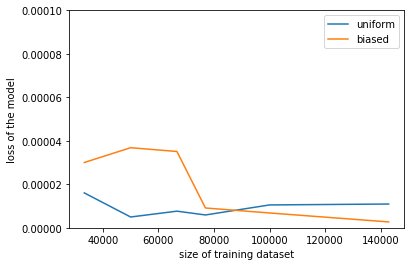

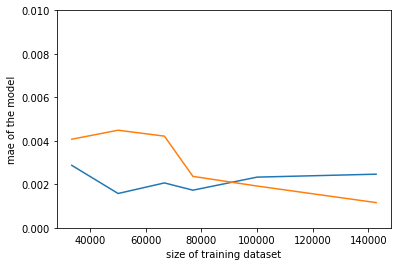

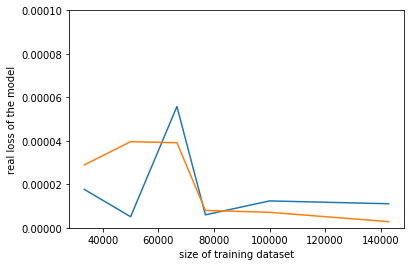

In [110]:
import matplotlib.pyplot as plt

uniform_loss = plt.plot(sizes, loss, label = "uniform")
biased_loss = plt.plot(sizes, new_loss, label = "biased")
plt.xlabel('size of training dataset')
plt.ylabel('loss of the model')
plt.ylim(0,0.0001)
plt.legend()
plt.show()

plt.plot(sizes, mae, label = "uniform")
plt.plot(sizes, new_mae, label = "biased")
plt.xlabel('size of training dataset')
plt.ylabel('mae of the model')
plt.ylim(0,0.01)
plt.show()

plt.plot(sizes, [ sub['loss'] for sub in real_test_stats], label = "uniform" )
plt.plot(sizes, [ sub['loss'] for sub in new_real_test_stats], label = "biased" )
plt.xlabel('size of training dataset')
plt.ylabel('real loss of the model')
plt.ylim(0,0.0001)
plt.show()
